<a href="https://colab.research.google.com/github/chandini193/sales_prediction/blob/master/DrugStoreSalesForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Declarative section


In [ ]:
import numpy as np
import pandas as pd
from pandas import datetime


#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import  ARIMA
import statsmodels.api as sm


#For generating cartesian product
import itertools

#For ignoring warnings
import warnings 
warnings.filterwarnings('ignore')

#for model creation
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Reading dataset


In [ ]:
train = pd.read_csv("/content/drive/My Drive/Dataset_project_3/train.csv",parse_dates = True, index_col = 'Date')

In [ ]:
store = pd.read_csv("/content/drive/My Drive/Dataset_project_3/store.csv")

In [ ]:
state = pd.read_csv("/content/drive/My Drive/Dataset_project_3/state.csv")

## Extraction of Data

In [ ]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']


# Displaying dataset

In [ ]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [ ]:
state.head()

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


In [ ]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data Description

In [ ]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [ ]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
state.describe()

,Store
count,1115.00000
mean,558.00000
std,322.01708
min,1.00000
25%,279.50000
50%,558.00000
75%,836.50000
max,1115.00000


# Checking null values


In [ ]:
train.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [ ]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
store['StoreType'].value_counts() 
# Obeservation :  Store b is very less in count comapre to a,c,d

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [ ]:
state.isnull().sum()

Store    0
State    0
dtype: int64

# Filling Missing values

In [ ]:
# Closed stores and zero sales stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1
2015-07-31,876,5,0,0,0,1,0,1
2015-07-30,292,4,0,0,0,1,0,1
2015-07-30,876,4,0,0,0,1,0,1
2015-07-29,292,3,0,0,0,1,0,1


In [ ]:
# opened stores with zero sales
train[(train.Open != 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1
2015-03-26,674,4,0,0,1,0,0,0
2015-02-05,699,4,0,0,1,1,0,0
2014-10-01,708,3,0,0,1,1,0,0
2014-09-22,357,1,0,0,1,0,0,0


In [ ]:
# Removing closed stores with zero sales
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

In [ ]:
train.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [ ]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
# fill NaN with a median value
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [ ]:
store.loc[290]

Store                         291
StoreType                       d
Assortment                      a
CompetitionDistance          2325
CompetitionOpenSinceMonth     NaN
CompetitionOpenSinceYear      NaN
Promo2                          0
Promo2SinceWeek               NaN
Promo2SinceYear               NaN
PromoInterval                 NaN
Name: 290, dtype: object

In [ ]:
store.loc[621]

Store                         622
StoreType                       a
Assortment                      c
CompetitionDistance          2325
CompetitionOpenSinceMonth     NaN
CompetitionOpenSinceYear      NaN
Promo2                          0
Promo2SinceWeek               NaN
Promo2SinceYear               NaN
PromoInterval                 NaN
Name: 621, dtype: object

In [ ]:
store.loc[878]

Store                                    879
StoreType                                  d
Assortment                                 a
CompetitionDistance                     2325
CompetitionOpenSinceMonth                NaN
CompetitionOpenSinceYear                 NaN
Promo2                                     1
Promo2SinceWeek                            5
Promo2SinceYear                         2013
PromoInterval                Feb,May,Aug,Nov
Name: 878, dtype: object

In [ ]:
# Replacing remaining all null values with 0
store.fillna(0, inplace = True)

In [ ]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

# Merging two datasets store and train

In [ ]:
# merging two datasets using inner join to identify how sales is influenced by other parameters
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

In [ ]:
train_store_state = pd.merge(train_store, state, how='inner', on ='Store');

In [ ]:
train_store_state.shape

(844338, 18)

In [ ]:
train_store_state.head(50)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
1,1,4,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
2,1,3,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
3,1,2,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
4,1,1,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
5,1,6,4364,500,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
6,1,5,3706,459,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
7,1,4,3769,503,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
8,1,3,3464,463,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE
9,1,2,3558,469,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,HE


In [ ]:
train_store_state.iloc[915:960]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
915,2,4,5842,627,1,1,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
916,2,3,6178,758,1,1,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
917,2,2,6113,623,1,1,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
918,2,1,7478,703,1,1,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
919,2,6,2809,351,1,0,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
920,2,5,3647,499,1,0,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
921,2,4,3765,485,1,0,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
922,2,3,4773,641,1,0,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
923,2,2,4653,567,1,0,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
924,2,1,3678,491,1,0,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH


In [ ]:
train_store_state.groupby('StoreType')['Sales'].describe()  # checking sales details on each store type

# Observation : count of store b is less but the average sales is very high when compared to others.

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [ ]:
train_store_state.groupby('StoreType')['Customers'].sum()
# Observation : store type a has highest number of customers
# Observation : store b have less number of customers but have high average sales

StoreType
a    363541431
b     31465616
c     92129705
d    156904995
Name: Customers, dtype: int64

# Correalation

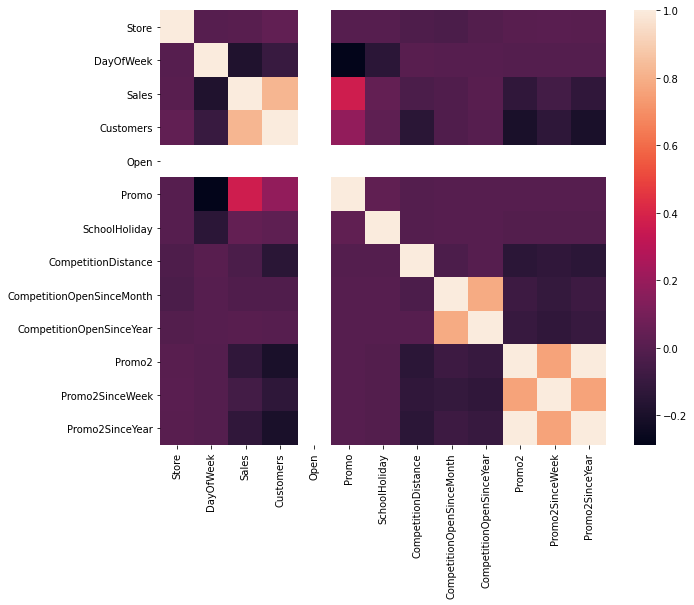

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(train_store.corr())

# Observation : sales is highly correalted to Customers, Open, Promo

# Plots

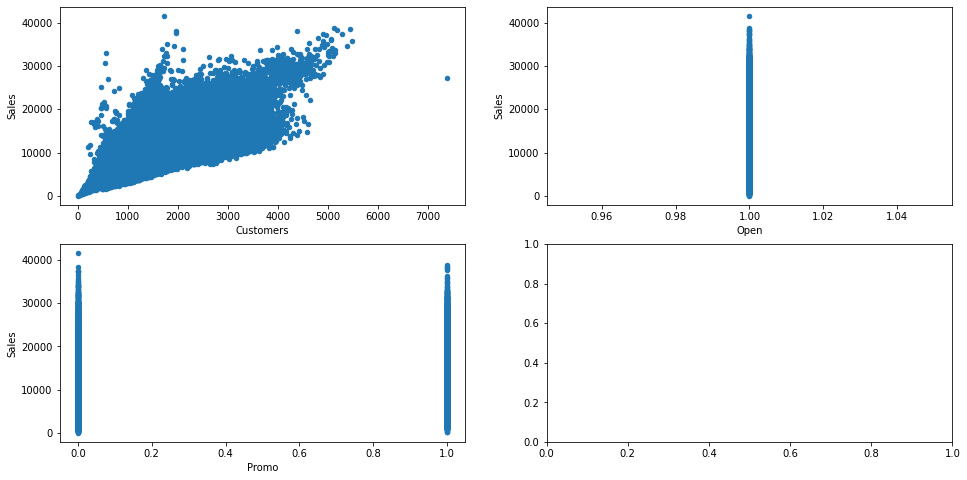

In [ ]:
fig,ax=plt.subplots(2,2)
train_store_state.plot(kind='scatter',x='Customers',y='Sales',ax=ax[0][0],figsize=(16,8))
train_store_state.plot(kind='scatter',x='Open',y='Sales',ax=ax[0][1])
train_store_state.plot(kind='scatter',x='Promo',y='Sales',ax=ax[1][0])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


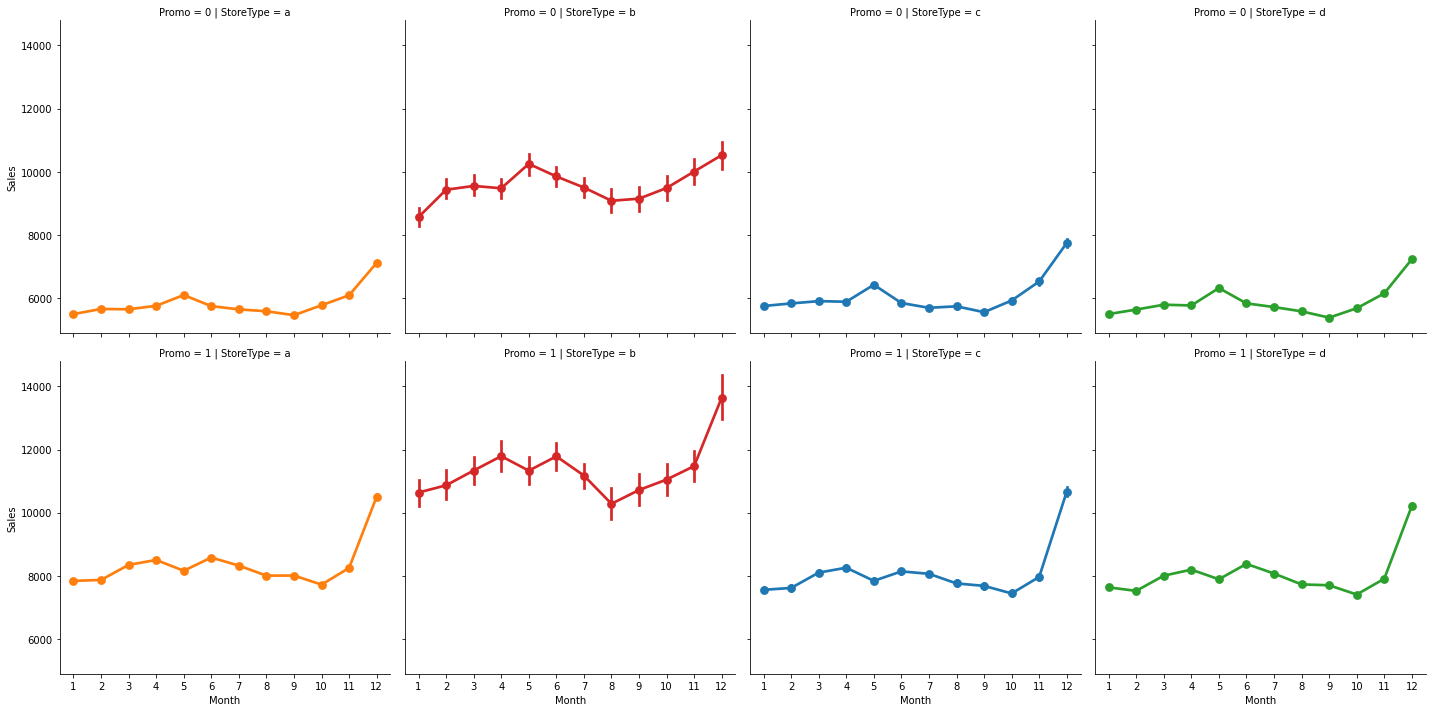

In [ ]:
# Sales with promotion and without promotion at different months
sns.factorplot(data = train_store_state, x = 'Month', y = "Sales", 
               hue = 'StoreType',
               col = 'StoreType', # per store type in cols
               row = 'Promo', # per promo in the store in rows
               col_order = ['a','b','c','d']
               ) 

# Observation : sales with promotion is high when compared to without promotion
# Observation : sales in december month is high

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


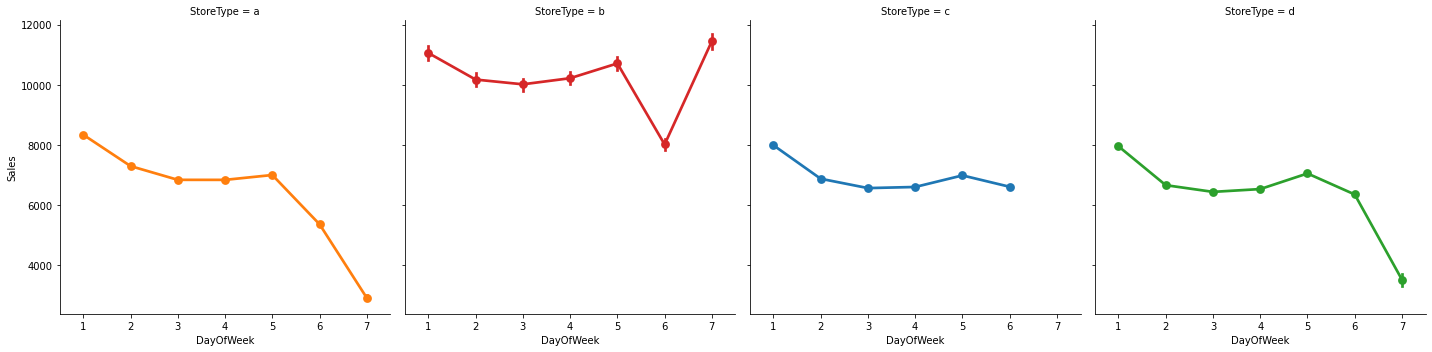

In [ ]:
# Sales at different DayOfWeek
sns.factorplot(data = train_store_state, x = 'DayOfWeek', y = "Sales", 
               hue = 'StoreType',
               col = 'StoreType', # per store type in cols
               col_order = ['a','b','c','d']
               ) 
# Observation : on 7th i.e weekend day the sales in decreasing in a,c and d but not in store of type b

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


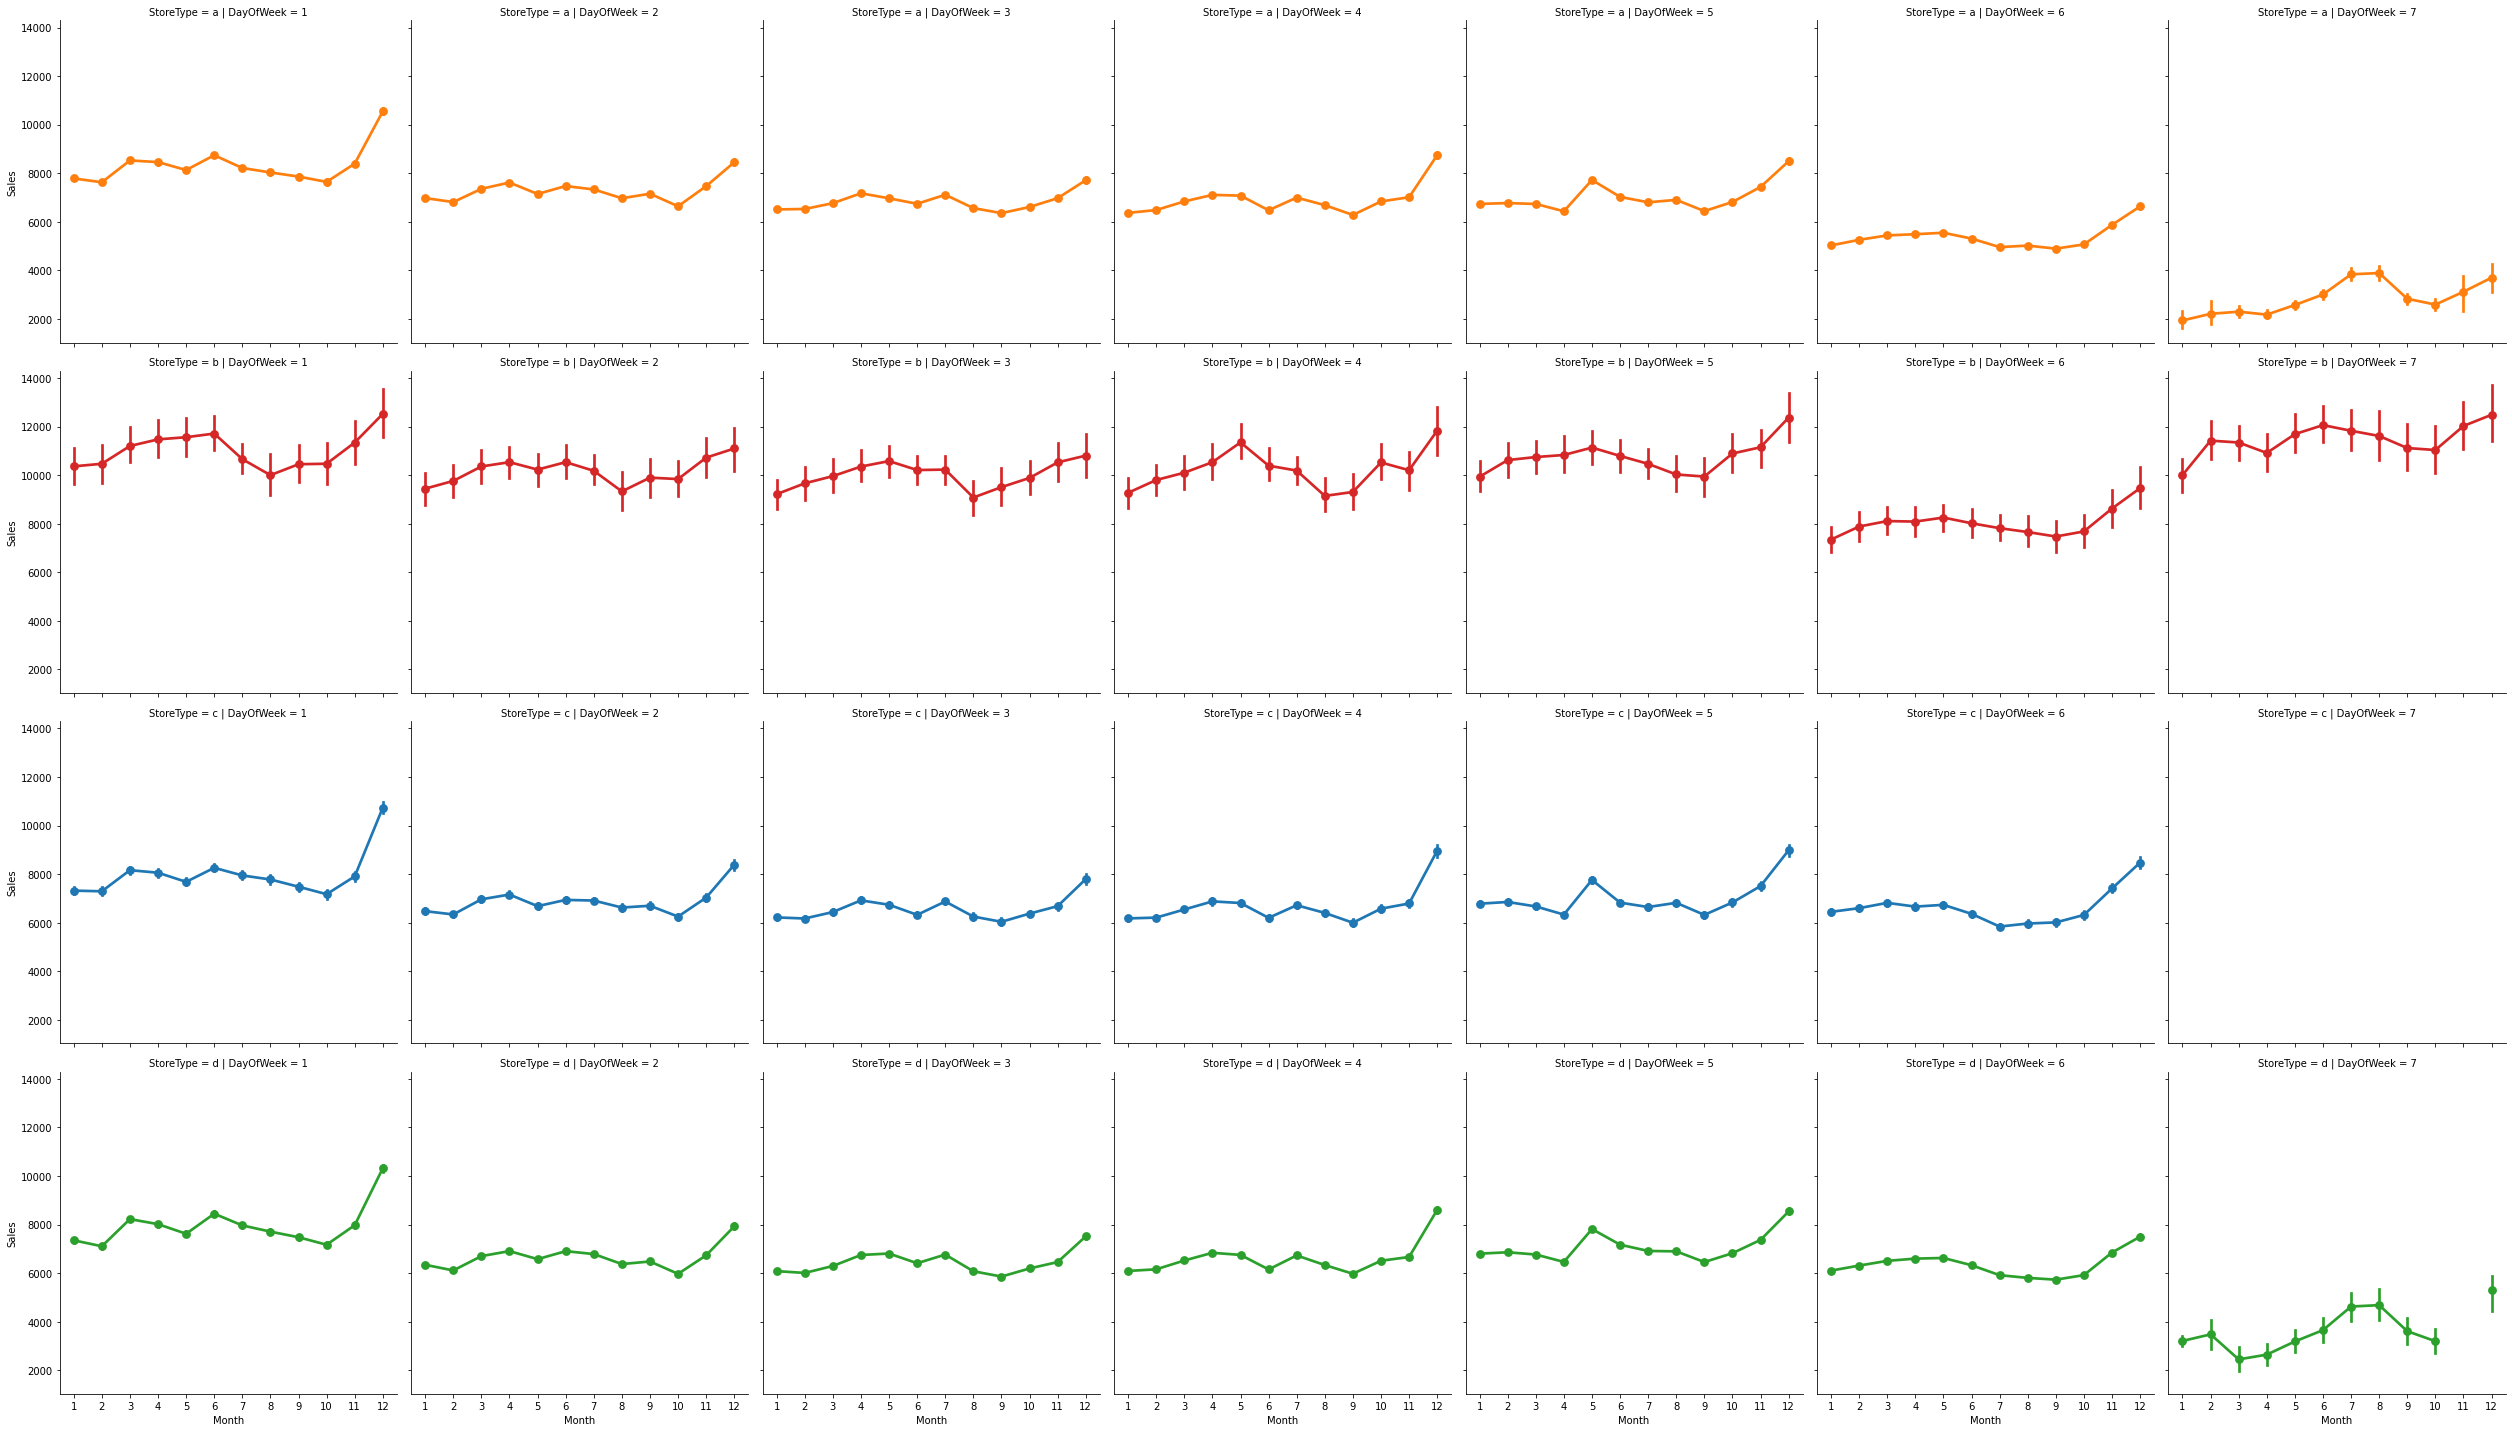

In [ ]:
# Sales at different DayOfWeek of different months
sns.factorplot(data = train_store_state, x = 'Month', y = "Sales", 
               hue = 'StoreType',
               col = 'DayOfWeek', # per day  in cols
               row = 'StoreType', # per store type in rows
               row_order = ['a','b','c','d']
               ) 
# Observation : Store type c are closed on sundays
# Observation : Store type d are closed from october to december on sundays

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


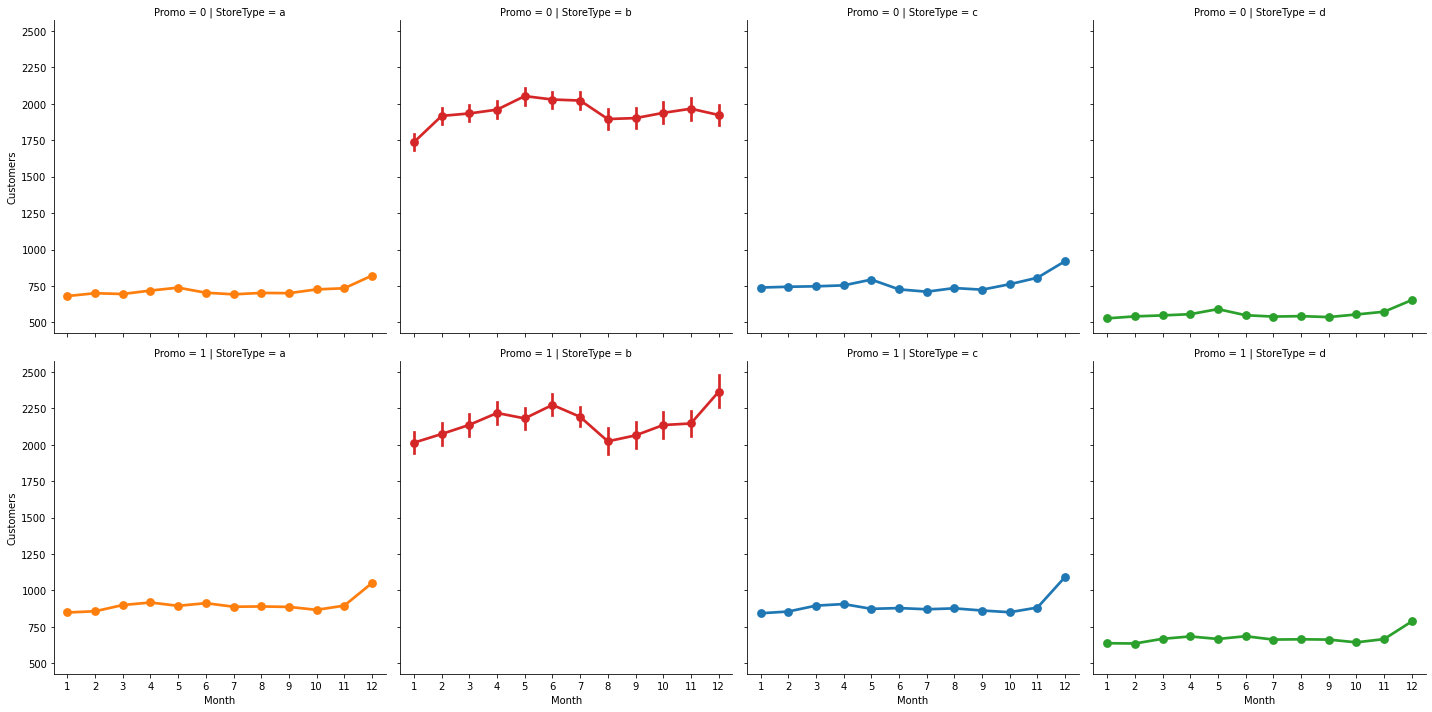

In [ ]:
# Customers with promotion and without promotion at different months
sns.factorplot(data = train_store_state, x = 'Month', y = "Customers", 
               hue = 'StoreType',
               col = 'StoreType', # per store type in cols
               row = 'Promo', # per promo in the store in rows
               col_order = ['a','b','c','d']
               ) 
# Observation : more number of customers visiting to store type b when compared to others
# Observation : the number of customers visiting is increased with promotion
# Observation : In the month of december the sales is high in almost all stores

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


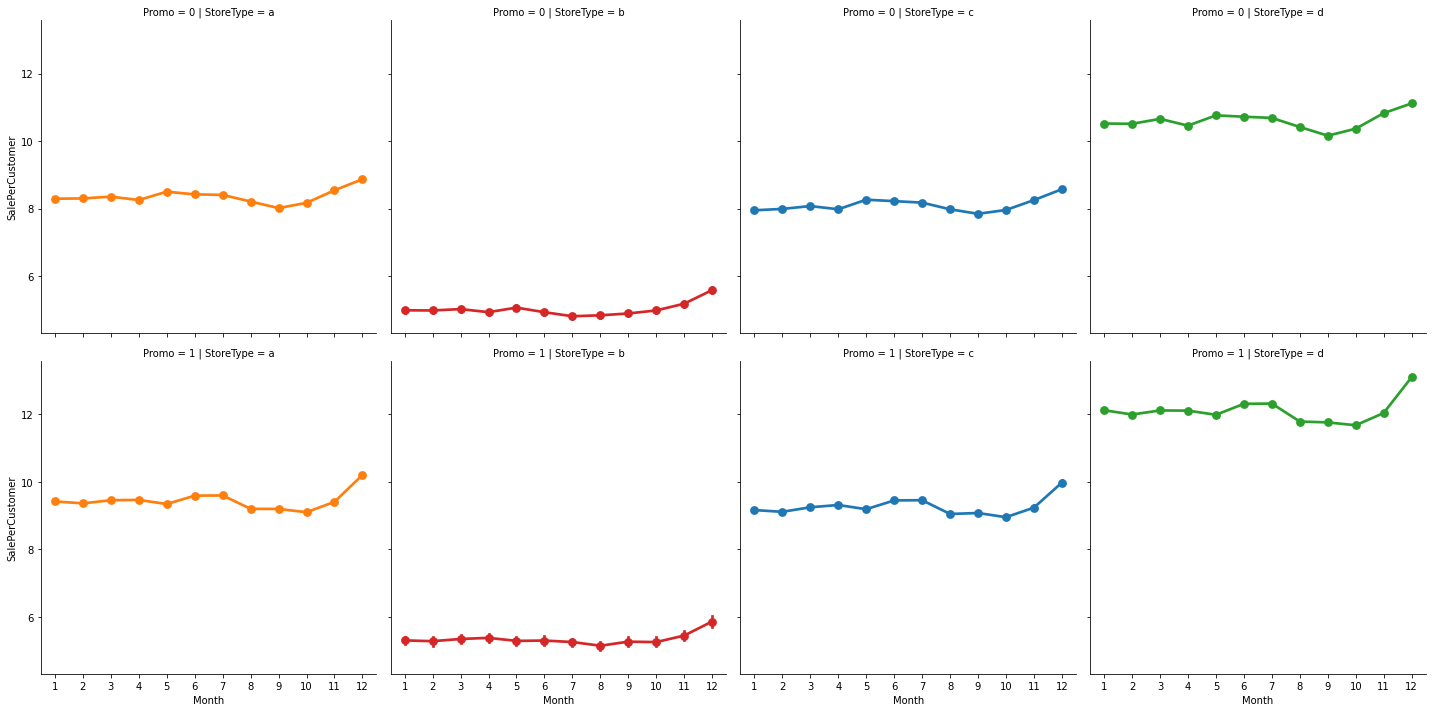

In [ ]:
#On an avreage SalePerCustomer of each month
sns.factorplot(data = train_store_state, x = 'Month', y = 'SalePerCustomer', 
               hue = 'StoreType',
               col = 'StoreType', # per store type in cols
               row = 'Promo', # per promo in the store in rows
               col_order = ['a','b','c','d']
               ) 
# Observation : Even though the sales and the no.of customers visiting StoreType b are more but the SalesPerCustomer is very less when compare to others.
# Means these are like retail shops.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


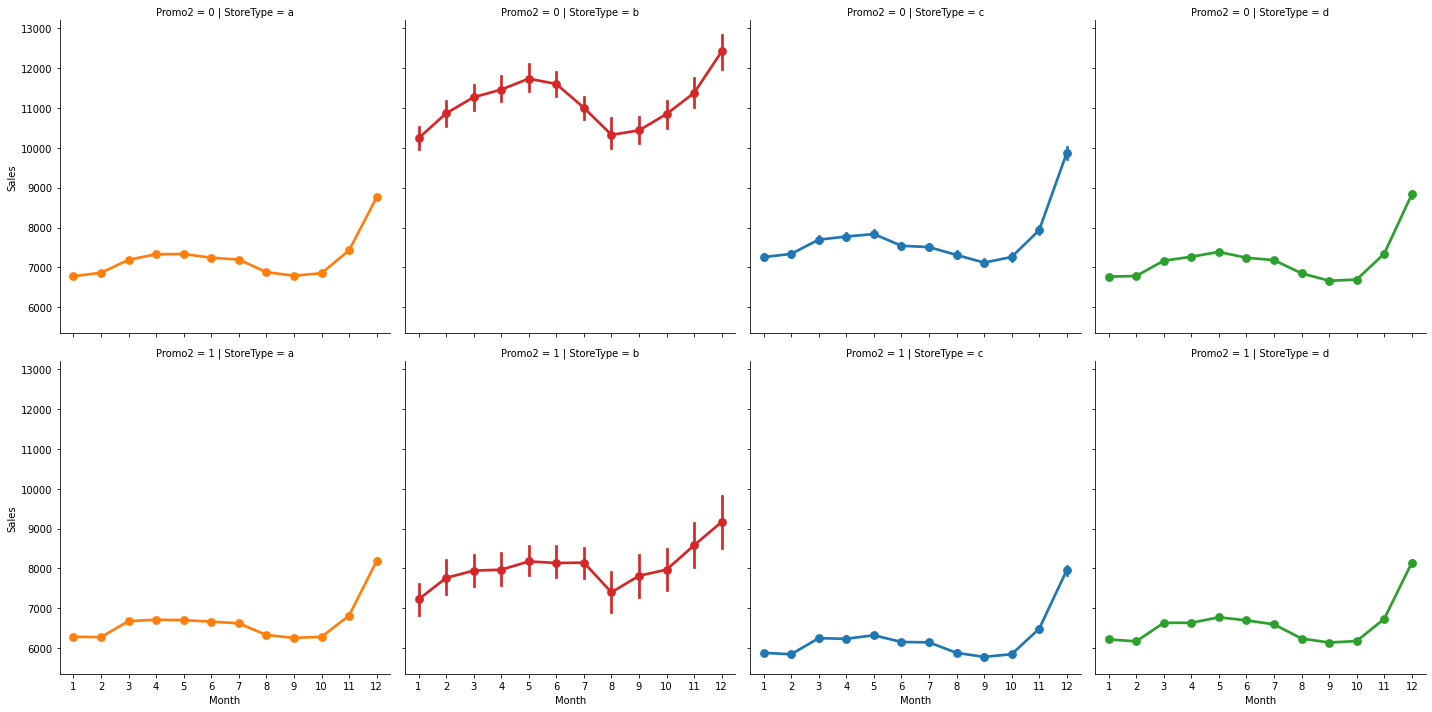

In [ ]:
# Sales with Promo2 and without Promo2 at different months
sns.factorplot(data = train_store_state, x = 'Month', y = 'Sales', 
               hue = 'StoreType',
               col = 'StoreType', # per store type in cols
               row = 'Promo2', # per promo2 in the store in rows
               col_order = ['a','b','c','d']
               ) 
# Observation : sales without longterm promotions is high

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


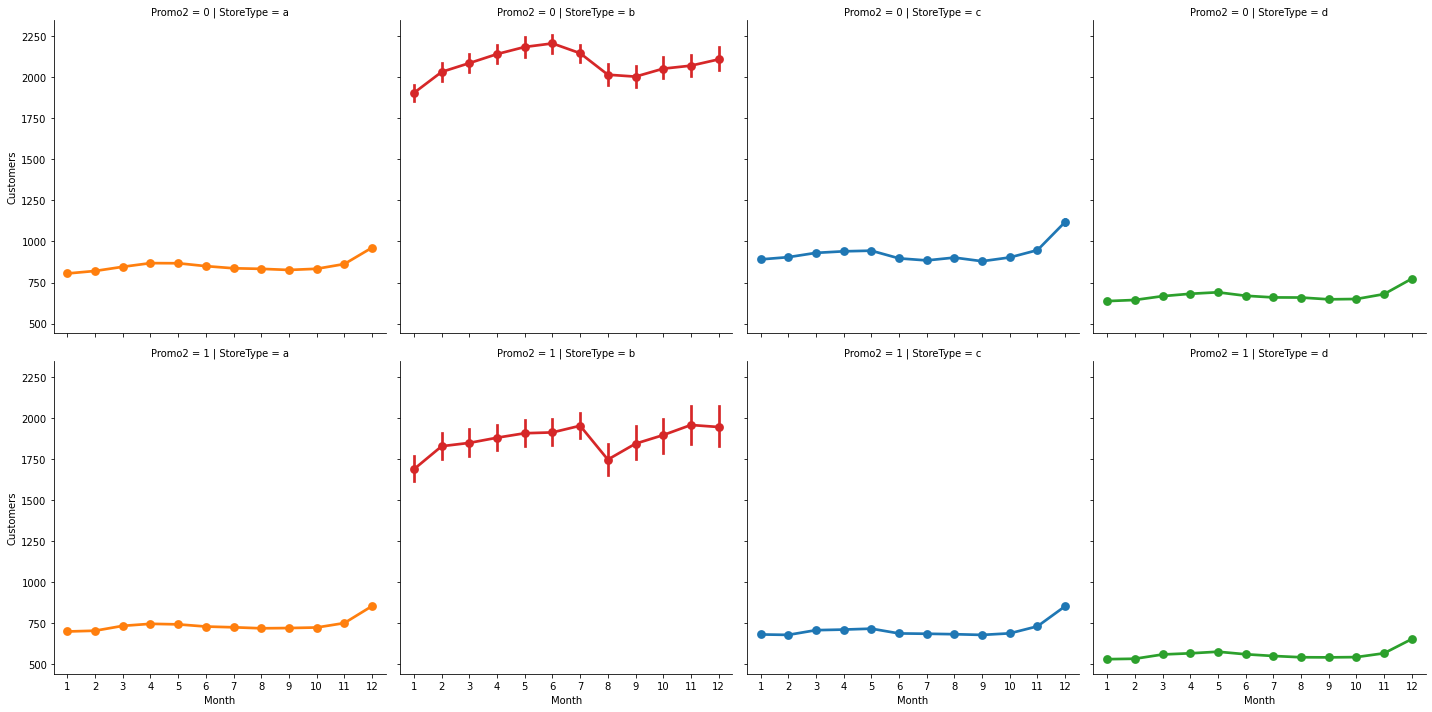

In [ ]:
# Customers with Promo2 and with out Promo2 at different months
sns.factorplot(data = train_store_state, x = 'Month', y = "Customers", 
               hue = 'StoreType',
               col = 'StoreType', # per store type in cols
               row = 'Promo2', # per promo in the store in rows
               col_order = ['a','b','c','d']
               ) 
# Observation : When there is longterm promotions the customers visting to stores is more but sales is less

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


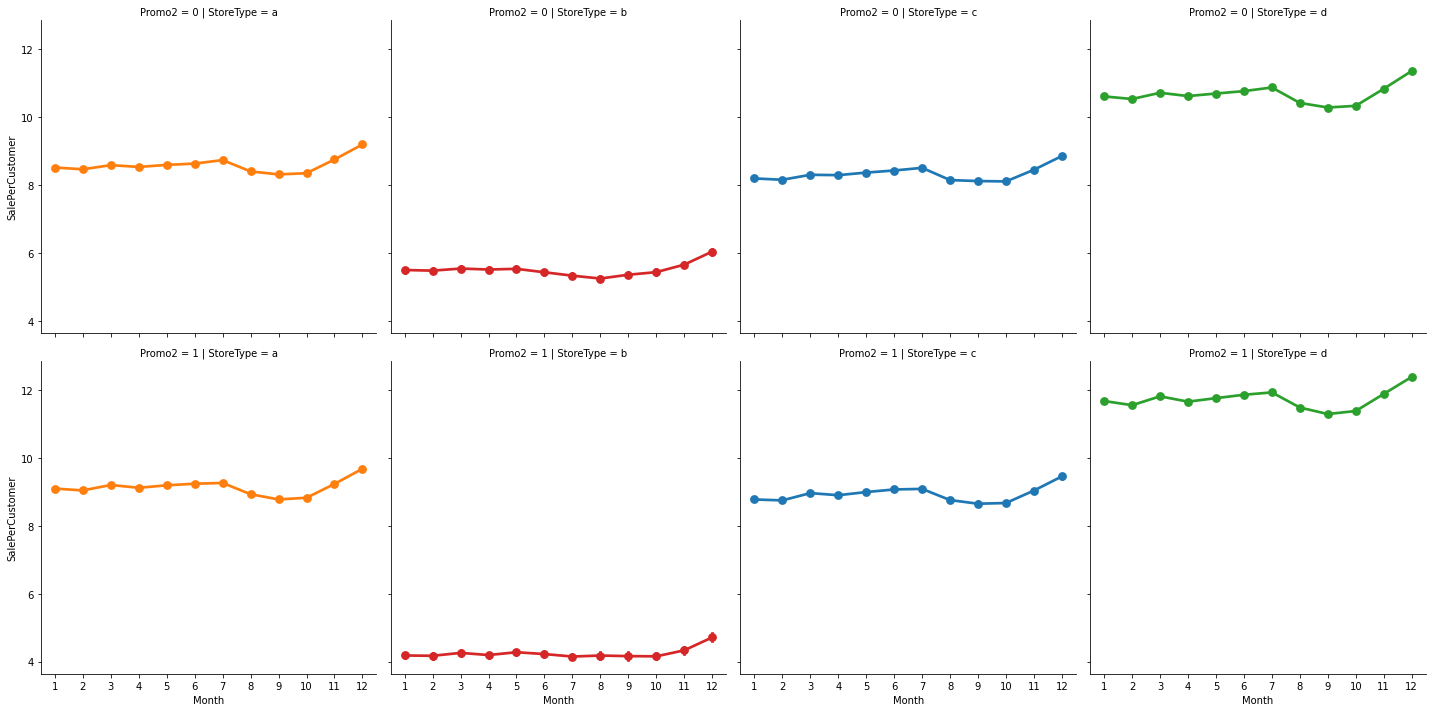

In [ ]:
#On an avreage SalesPerCustomer of each month
sns.factorplot(data = train_store_state, x = 'Month', y = 'SalePerCustomer', 
               hue = 'StoreType',
               col = 'StoreType', # per store type in cols
               row = 'Promo2', # per promo2 in the store in rows
               col_order = ['a','b','c','d']
               ) 
# Observation :  In 7 month sales is high in all other stores except in store b
# Observation : When there is long term promotion SalsePerCustomer is increasing

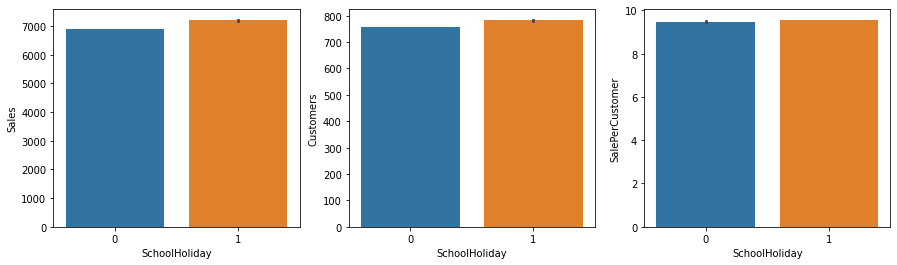

In [ ]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=train_store_state, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=train_store_state, ax=axis2)
sns.barplot(x='SchoolHoliday',y='SalePerCustomer',data=train_store_state,ax=axis3)
# Observation : Sales,Customers,SalePerCustomer are high when there is school holiday compared to workingdays

In [ ]:
train_store_state['StateHoliday'] = train_store_state.StateHoliday.astype(str)

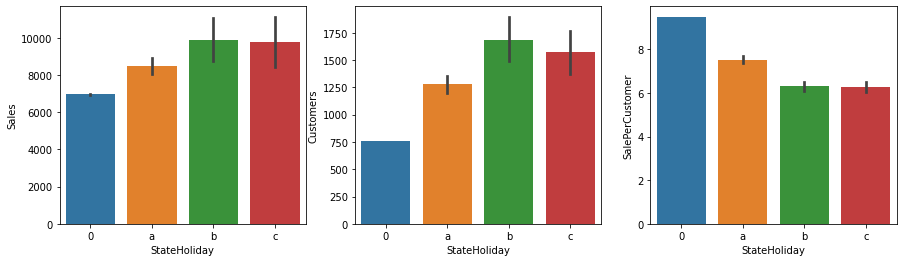

In [ ]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=train_store_state, ax=axis1)
sns.barplot(x='StateHoliday', y='Customers', data=train_store_state, ax=axis2)
sns.barplot(x='StateHoliday',y='SalePerCustomer',data=train_store_state,ax=axis3)
# Observation : Here a,b,c are public and festival holidays, in this time sales are high.

Text(0.5, 1.0, 'Number of Different Assortments per Store Type')

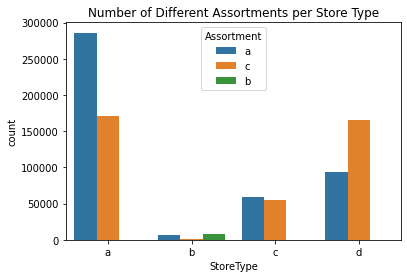

In [ ]:
sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"], data=train_store_state).set_title("Number of Different Assortments per Store Type")
# Observation : assortment type b is only available in store b
# Observation : assortment type a is more in store a

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


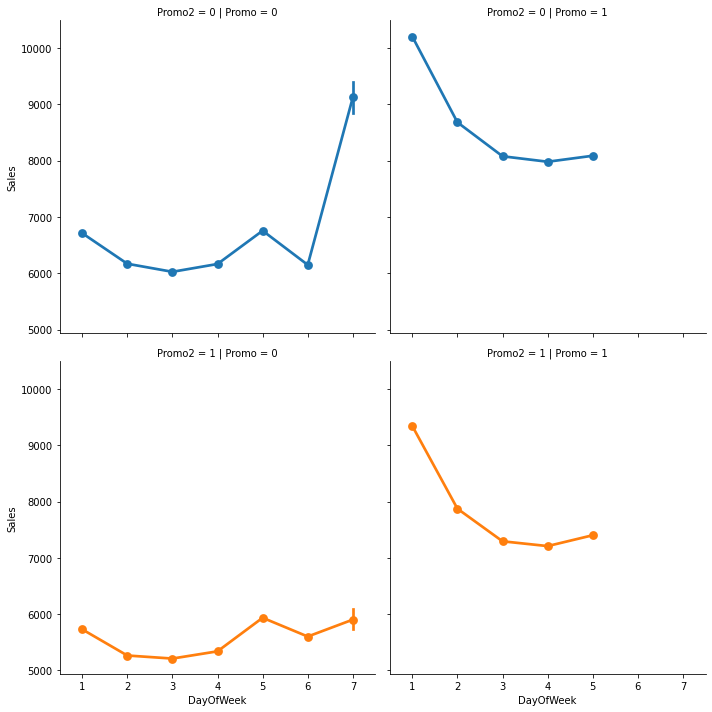

In [ ]:
# sales per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = 'Sales', 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
              ) 

# Observation : No promotion on weekends
# Observation : Promo and Promo2 are equal to 0, Sales tend to peak on Sunday. We know StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D.
# Observation : stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time.
# Observation : Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


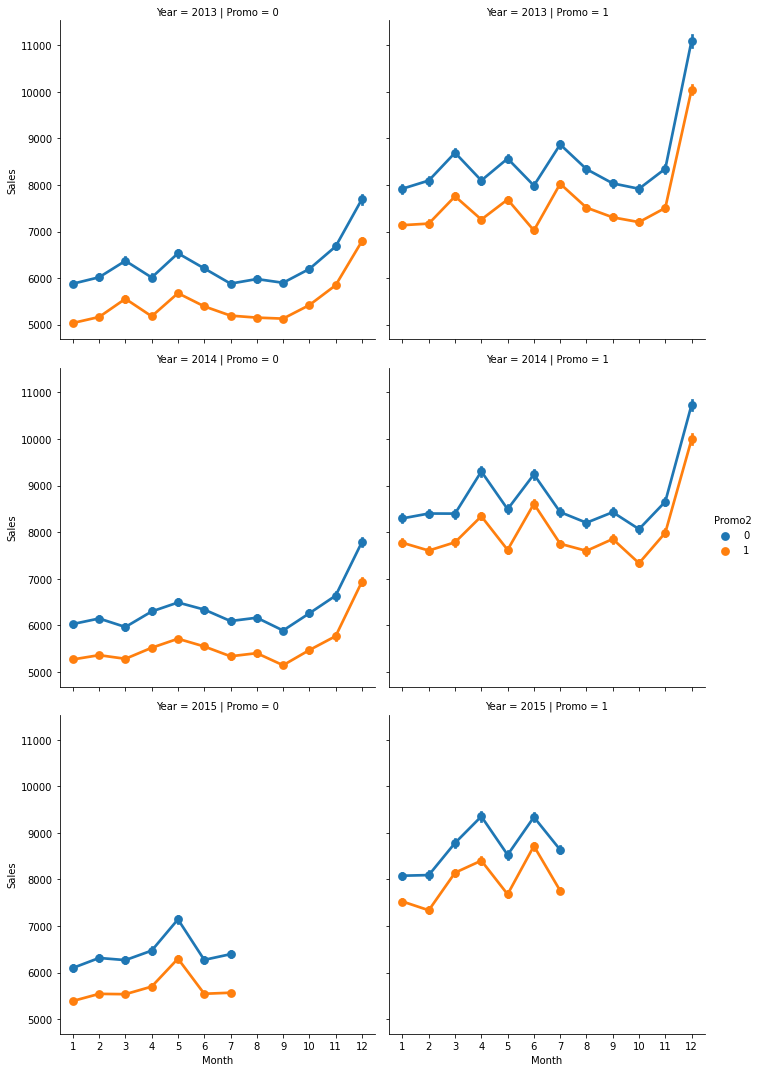

In [ ]:
# Sales trend over the months and year
sns.factorplot(data = train_store_state, x ='Month', y = 'Sales', 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = 'Year')
# Observation : Sales tend to spike in December, which makes sense because of the Christmas and holiday season. So, this confirms that the sales vary with the ‘Date’ (time) and there is a seasonality factor present in our data.

## Model

# ARIMA - AutoRegressive Integrated Moving Averages

process of ARIMA model:
1. Visualize time series data
2. Make the time series data stationary i.e without any trends
3. Plot correlation and auto correlation charts for identifying lags
4. Construct SARIMA model
5. Use the model to make predictions

## Checking stationarity

In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time i.e no seasonality.

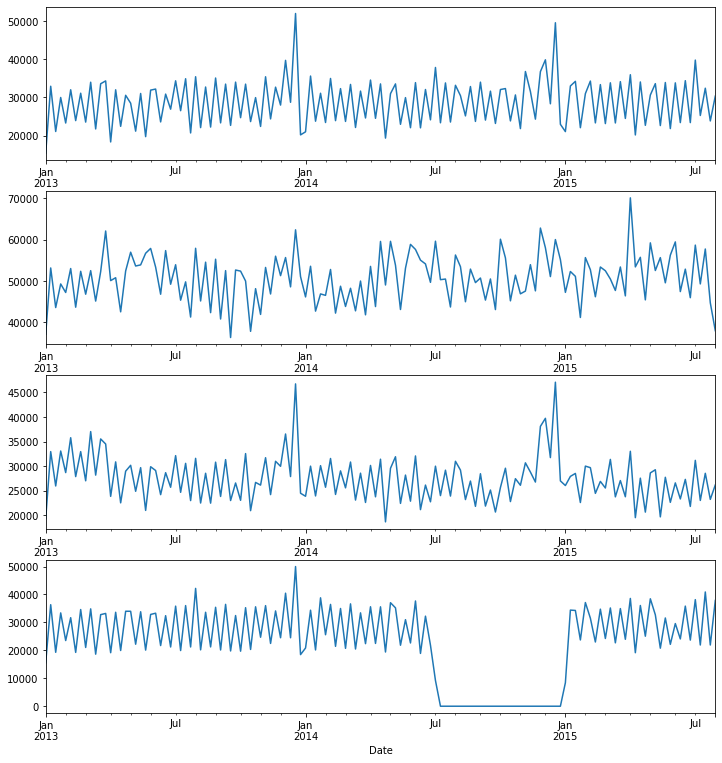

In [ ]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # sort the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types resampling form days to weeks to see tends more clearly
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

## Augmented Dicky-Fuller test
H0 : Time series is non-stationary.

H1 : Time series is stationary.

So, if the p-value of the test is less than the significance level (< 0.05) then reject the null hypothesis and infer that the time series is indeed stationary.

In [ ]:
print('Results of Dickey-Fuller Test:')
result = adfuller(sales_a, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print(key, value)

Results of Dickey-Fuller Test:
ADF Statistic: -5.292708
p-value: 0.000006
Critical Values:
1% -3.438915730045254
5% -2.8653205426302253
10% -2.5687831424305845


In [ ]:
print('Results of Dickey-Fuller Test:')
result = adfuller(sales_b, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print(key, value)

Results of Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [ ]:
print('Results of Dickey-Fuller Test:')
result = adfuller(sales_c, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print(key, value)

Results of Dickey-Fuller Test:
ADF Statistic: -5.412786
p-value: 0.000003
Critical Values:
1% -3.4389045244994096
5% -2.8653156040031176
10% -2.5687805115003


In [ ]:
print('Results of Dickey-Fuller Test:')
result = adfuller(sales_d, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print(key, value)

Results of Dickey-Fuller Test:
ADF Statistic: -6.321001
p-value: 0.000000
Critical Values:
1% -3.4411511898545206
5% -2.866305414688104
10% -2.569307861950312


## Auto Correlation & Partial Auto Correlation

AC =  Direct + Indirect effect of lags on today day sales.
Example : today salses is effected by yesterday and day before yesterday directly. And day before yesterday's imapact on yesterday effectes today sales indirectly. 

PAC = Direct effect of lags on todays sales.

For Auto Regression i.e p we use PACF

For Moving Average i.e q we use ACF

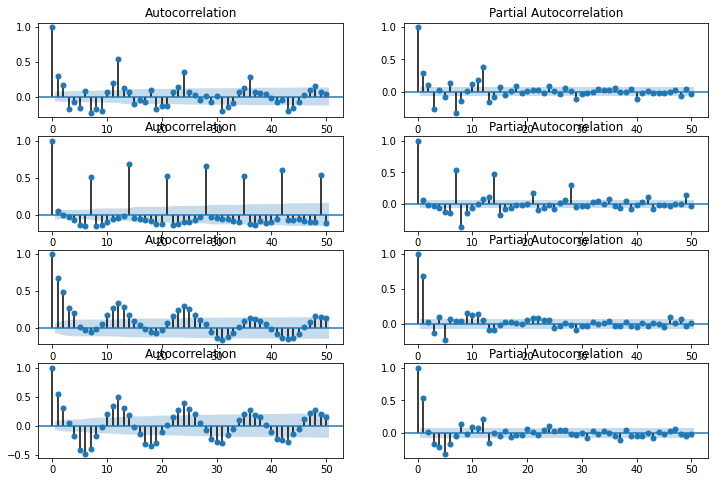

In [ ]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(4,2,1) # four rows, each row 2 columns, and the position of this graph
plot_acf(sales_a, lags = 50, ax = plt.gca())
plt.subplot(4,2,2)
plot_pacf(sales_a, lags = 50, ax = plt.gca())

# acf and pacf for B
plt.subplot(4,2,3)
plot_acf(sales_b, lags = 50, ax = plt.gca())
plt.subplot(4,2,4)
plot_pacf(sales_b, lags = 50, ax = plt.gca())

# acf and pacf for C
plt.subplot(4,2,5)
plot_acf(sales_c, lags = 50, ax = plt.gca())
plt.subplot(4,2,6)
plot_pacf(sales_c, lags = 50, ax = plt.gca())

# acf and pacf for D
plt.subplot(4,2,7)
plot_acf(sales_d, lags = 50, ax = plt.gca())
plt.subplot(4,2,8)
plot_pacf(sales_d, lags = 50, ax = plt.gca())

plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) #computes the cartesian product of input iterables i.e all possibe combinatios of p, d, q between 0 and 2
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [ ]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] # For seasonal parameters P, D, Q
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

# Hyper Parameter Tuning
The best combination of parameters will give the lowest Akaike information criterion (AIC) score. AIC tells us the quality of statistical models for a given set of data.

In [ ]:
train = pd.read_csv("/content/drive/My Drive/Dataset_project_3/train.csv",parse_dates = True, index_col = 'Date')
y = train['Sales'].resample('W').mean()
y.shape

(135,)

In [ ]:
import warnings 
warnings.filterwarnings('ignore')
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
            model = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.2039807690685
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207667
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.8220522797478
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.705791267345
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857754
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107421366
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.3366943415576
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.886830503404
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.0171891135674
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.6353259664575
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.042617135911
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.908590968404
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.441508975251
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.884184252758
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.5804531929857


In [ ]:
import warnings 
warnings.filterwarnings('ignore')

# Fitting the data to ARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sarima = model_sarima.fit()
print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5251      0.103     -5.091      0.000      -0.727      -0.323
ma.L1         -0.9559      0.050    -19.076      0.000      -1.054      -0.858
ma.S.L12      -1.0120      0.831     -1.218      0.223      -2.640       0.616
sigma2      8.268e+05   7.31e+05      1.131      0.258   -6.06e+05    2.26e+06


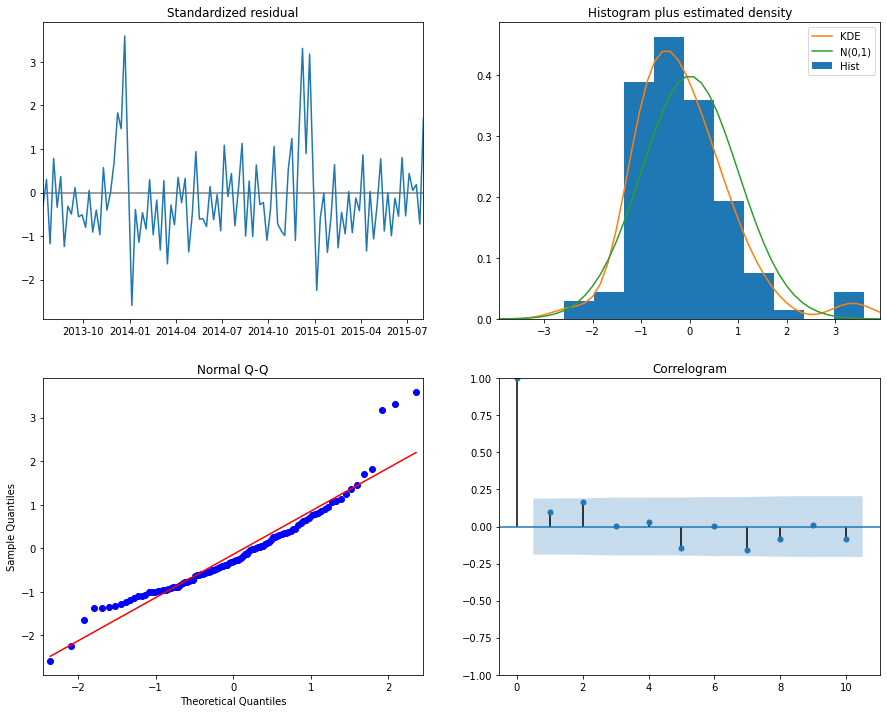

In [ ]:
results_sarima.plot_diagnostics(figsize=(15, 12))
plt.show()

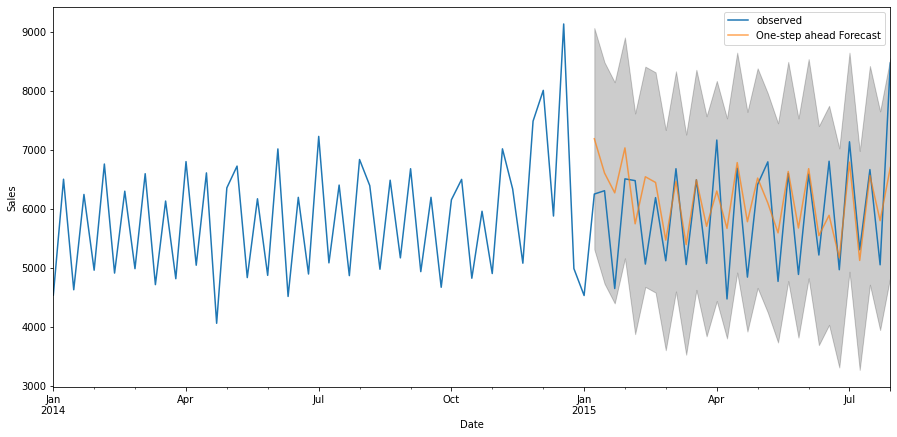

In [ ]:
# Model Prediction

pred = results.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic=False) # Predictions are performed for the 11th Jan 2015 onwards of the train data.
#The dynamic=False argument ensures that forecasts at each point are generated using the full history up to that point.
pred_ci = pred.conf_int() # Get confidence intervals of forecasts


ax = y['2014':].plot(label='observed',figsize=(15, 7))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2015-01-11':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 569704.18


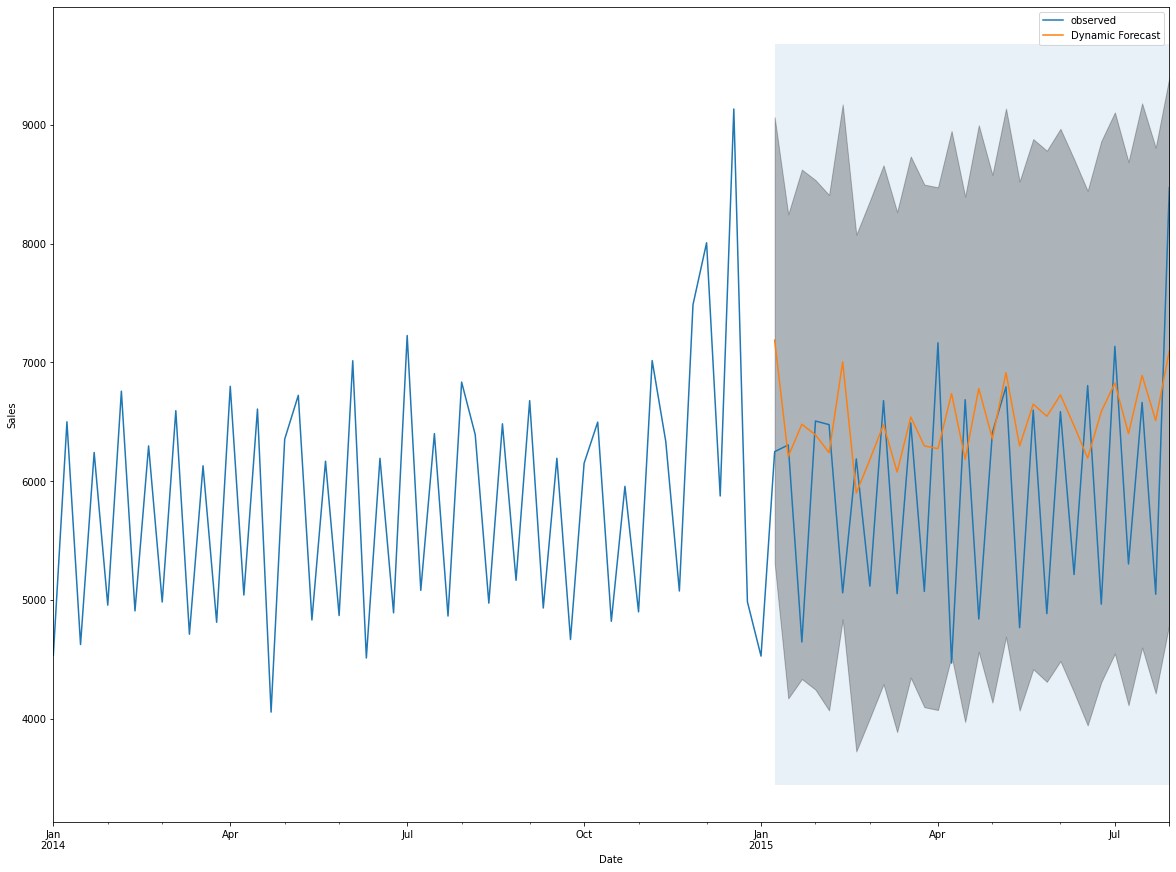

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic=True, full_results=True) 
#Dynamic forecast uses the value of the previous forecasted value of the dependent variable to compute the next one.
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y['2014':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-11'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2015-01-11':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1232079.9


In [ ]:
# Get forecast 6 steps i.e 6 weeks ahead in future
pred_uc = results.get_forecast(steps=6)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

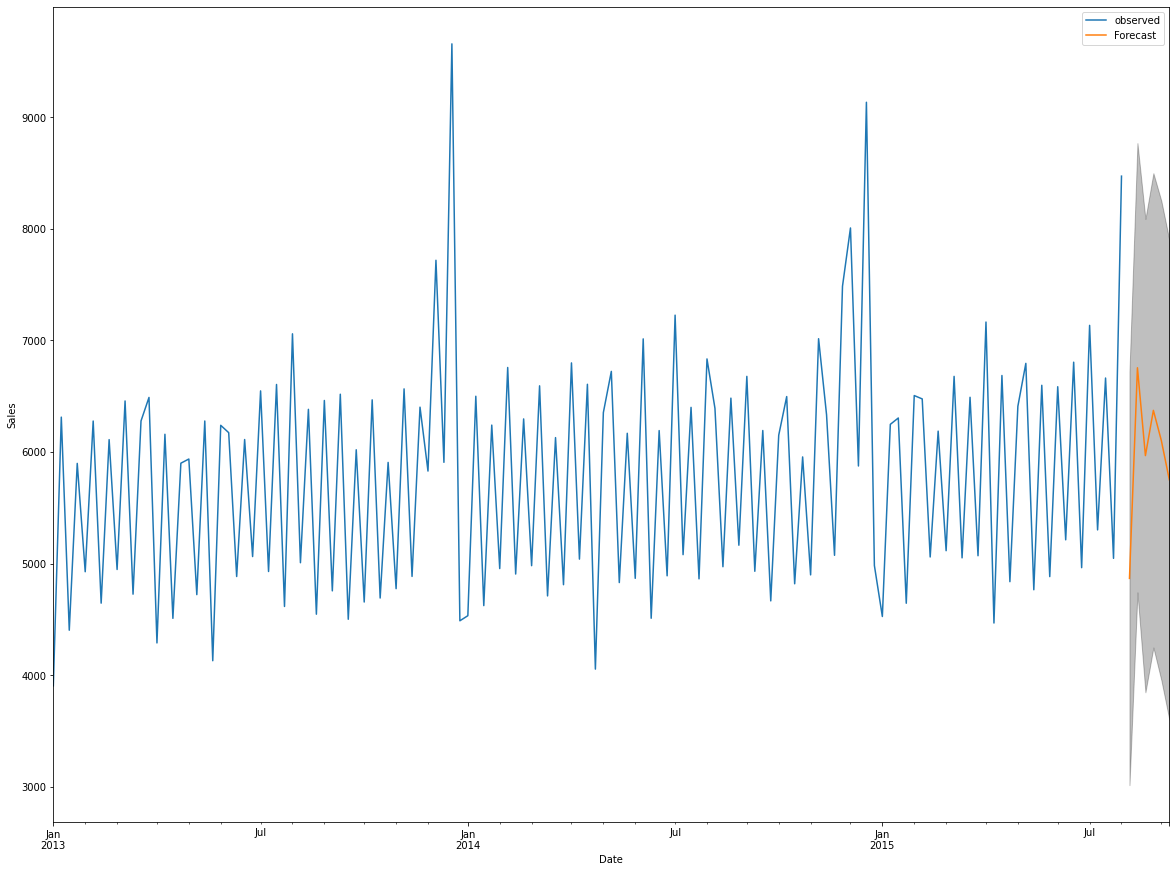

In [ ]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()